# Imports and custom functions

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
from random import shuffle
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import random

def get_all_indices(mylist, myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

# unipartite positive and negative layers ...k01, k10 are column vectors
def multidegree_entropy_pos_neg(k01, k10, precision=10**(-5), loops=10000):
    n=len(k01)
    t01=np.random.uniform(size=(n,1))
    t10=np.random.uniform(size=(n,1))
    oldt01=np.random.uniform(size=(n,1))
    oldt10=np.random.uniform(size=(n,1))    
    
    for kk in tqdm(range(loops)):
            T01=t01*(t01.transpose())
            T10=t10*(t10.transpose())
            Z=1+ T01 + T10
            
            #p01
            summat=(np.ones((n,1))*t01.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1, keepdims=True);
            t01=k01/(summat+(summat==0))
            T01=t01*(t01.transpose())
            
            Z=1+ T01 + T10
    
            #p10
            summat=(np.ones((n,1))*t10.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1,keepdims=True)
            t10=k10/(summat+(summat==0))
            
            #print((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))))
            
            #print(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0))))))
            
            if np.logical_and((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))< precision),(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))<precision)):
                break

            oldt01=t01
            oldt10=t10
            
            
    print("Loops ", kk+1)
    print('Error margin: ', max((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))),max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))))
    T01=t01*(t01.transpose());
    T10=t10*(t10.transpose());

    Z=1+ T01 + T10;
    
    
    summat01=T01/(Z+(Z==0))
    summat01=summat01-np.diag(np.diagonal(summat01))
    k01cal=np.sum(summat01,axis=1,keepdims=True);  
    
    summat10=T10/(Z+(Z==0))
    summat10=summat10-np.diag(np.diagonal(summat10))
    k10cal=np.sum(summat10,axis=1,keepdims=True)
                    
    pconditional=summat10/(summat10+summat01+(summat10==0))
    
    return (summat01, k01cal, summat10, k10cal, pconditional)   

    return network_data

def run_configuration_model(network_data, precision=10**(-5), loops=10000):

    ## Create train-test split

    train, test = train_test_split(network_data, test_size=0.3)

    train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
    train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

    degree_train_1_0 = []
    degree_train_0_1 = []

    for node in tqdm(train_nodes):
        sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
        degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
        degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
    ## Degree ratio distirbution

    degree_ratio_list = [degree_train_1_0[i]/(degree_train_1_0[i] + degree_train_0_1[i]) for i in range(len(train_nodes))]

    figure(figsize=(8, 8))
    ax = sns.distplot(degree_ratio_list, norm_hist=True, hist_kws=dict(alpha=0.1))
    ax.set(xlim = [0,1], xlabel=r'$\rho$', ylabel='PDF')
    plt.show()

    sum_degree =  [a + b for a,b in zip(degree_train_1_0,degree_train_0_1)]
    print('Number of nodes with not positive or negative annotation: ', sum_degree.count(0))

    print('Validating p_bind value from binary labels: ', network_data['binary_label'].tolist().count(1) / len(network_data))

    summat01, k01cal, summat10, k10cal, pconditional = multidegree_entropy_pos_neg(np.array([degree_train_0_1]).T, np.array([degree_train_1_0]).T, precision=precision, loops=loops)

    test_probabilty_predicted_conditioned = []
    test_type_list = []

    ## Average conditional probability
    p10_avg = np.mean(summat10)
    p01_avg = np.mean(summat01)
    average_conditional_probability = p10_avg / (p10_avg + p01_avg)

    for index, row in tqdm(test.iterrows()):      
    
        if row['node_1'] in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = pconditional[mapped_index_in_matrix_node_1, mapped_index_in_matrix_node_2]
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Transductive')
        
        elif row['node_1'] in train_nodes and row['node_2'] not in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_1] / (degree_train_0_1[mapped_index_in_matrix_node_1] + degree_train_1_0[mapped_index_in_matrix_node_1] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        elif row['node_1'] not in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_2] / (degree_train_0_1[mapped_index_in_matrix_node_2] + degree_train_1_0[mapped_index_in_matrix_node_2] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        else:
            p10_conditioned = average_conditional_probability
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Inductive')
        
    test_predictions = test.copy()
    test_predictions['predicted_probability'] = test_probabilty_predicted_conditioned
    test_predictions['test_type'] = test_type_list

    ## Performance on the test dataset

    print('AUC: ', roc_auc_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))

    print('Transductive performance:')

    test_predictions_transductive = test_predictions[test_predictions['test_type'] == 'Transductive']
    print('AUC: ', roc_auc_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))

    figure(figsize=(8, 8))
    #ax = sns.distplot(test_predictions['predicted_probability'].tolist(), norm_hist=True, hist_kws=dict(alpha=0.1))
    ax = sns.distplot(test_predictions_transductive['predicted_probability'].tolist(), norm_hist=True, hist_kws=dict(alpha=0.1))
    ax.set(xlim = [0,1], xlabel='$p^{conditional}$', ylabel='PDF')
    plt.show()
    
    return

def correlated_networks(kvec, p_bind=0.5): ## Uses anti-correlation between k and Kd with varying fluctuations 
    avgk=np.mean(kvec)
    ecdfK =ECDF(kvec)
    x=ecdfK.x[1:]
    y=ecdfK.y[1:]
    lm=[dict_association[k][0] for k in x]
    ls=[dict_association[k][1] for k in x]
    MAT=np.array([x, y, poisson.ppf(y, avgk), lm, ls]).T
    MAT[-1,2]=poisson.ppf((MAT.shape[0]-0.5)/MAT.shape[0], avgk)
    
    node2lm={n: lm[n] for n in range(len(lm)) }
    node2ls={n: ls[n] for n in range(len(ls)) }
    
    # fat-tailed network
    Goriginaldegree= nx.configuration_model(MAT[:,0].astype(int), create_using=nx.Graph(), seed=None)
    Goriginaldegree.remove_edges_from(nx.selfloop_edges(Goriginaldegree))
    nx.set_node_attributes(Goriginaldegree, node2lm, "m")
    nx.set_node_attributes(Goriginaldegree, node2ls, "s")
    
    # poisson network
    Gpoisson= nx.configuration_model(MAT[:,2].astype(int),create_using=nx.Graph(), seed=None)
    Gpoisson.remove_edges_from(nx.selfloop_edges(Gpoisson))    
    nx.set_node_attributes(Gpoisson, node2lm, "m")
    nx.set_node_attributes(Gpoisson, node2ls, "s")  
    
    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(Goriginaldegree.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(np.exp(norm.rvs(loc=Goriginaldegree.nodes[edge[0]]['m'], scale=Goriginaldegree.nodes[edge[0]]['s'])))
        node_Kd_list_2.append(np.exp(norm.rvs(loc=Goriginaldegree.nodes[edge[1]]['m'], scale=Goriginaldegree.nodes[edge[1]]['s'])))

    
    network_dataOrig = pd.DataFrame()
    network_dataOrig['node_1'] = node_list_1
    network_dataOrig['node_2'] = node_list_2
    network_dataOrig['node_1_Kd'] = node_Kd_list_1
    network_dataOrig['node_2_Kd'] = node_Kd_list_2
    network_dataOrig['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]

    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(Gpoisson.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(np.exp(norm.rvs(loc=Gpoisson.nodes[edge[0]]['m'], scale=Gpoisson.nodes[edge[0]]['s'])))
        node_Kd_list_2.append(np.exp(norm.rvs(loc=Gpoisson.nodes[edge[1]]['m'], scale=Gpoisson.nodes[edge[1]]['s'])))

    
    network_dataPois = pd.DataFrame()
    network_dataPois['node_1'] = node_list_1
    network_dataPois['node_2'] = node_list_2
    network_dataPois['node_1_Kd'] = node_Kd_list_1
    network_dataPois['node_2_Kd'] = node_Kd_list_2
    network_dataPois['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]
    
    
    Kd_for_edges = network_dataOrig['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))
    print('Threshold Fat-tailed: ', threshold) ## in nM
    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]
    network_dataOrig['binary_label'] = binary_labels
    
    Kd_for_edges = network_dataPois['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))
    print('Threshold Poisson: ', threshold) ## in nM
    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]
    network_dataPois['binary_label'] = binary_labels  
    
    return   Goriginaldegree, Gpoisson, network_dataOrig, network_dataPois

def remove_zeros_distribution(x):

    return [i for i in x if i != 0]

def log_binning_distribution(x_i, B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))
   
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

def plot_k_Kd_relation(network_data):
       
    nodes = list(set(network_data['node_1']).union(set(network_data['node_2'])))

    K_from_copula_list = []
    Kd_from_copula_list = []
    log_Kd_from_copula_list = []

    for node in tqdm(nodes):
        sub_df = network_data[(network_data['node_1'] == node) | (network_data['node_2'] == node)]
        K_from_copula_list.append(len(sub_df))
        Kd_from_copula_list.append(np.mean(sub_df['edge_Kd'].tolist()))
        log_Kd_from_copula_list.append(np.mean(np.log(sub_df['edge_Kd'].tolist())))

    different_target_annotations_copula = list(set(K_from_copula_list))
    unique_Kd_targets_copula = []
    unique_Kd_std_targets_copula = []
    unique_log_Kd_targets_copula = []
    unique_log_Kd_std_targets_copula = []

    for unique_ann in tqdm(different_target_annotations_copula):
    
        all_Kd_list = []  
        all_log_Kd_list = []
        all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list.append(Kd_from_copula_list[j])
            all_log_Kd_list.append(log_Kd_from_copula_list[j])
        
        unique_Kd_targets_copula.append(np.mean(all_Kd_list))
        unique_Kd_std_targets_copula.append(np.std(all_Kd_list))
        unique_log_Kd_targets_copula.append(np.mean(all_log_Kd_list))
        unique_log_Kd_std_targets_copula.append(np.std(all_log_Kd_list))
        
    print('Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))
    
    figure(figsize=(8, 8))
    plt.errorbar(different_target_annotations_copula, unique_Kd_targets_copula, yerr=unique_Kd_std_targets_copula, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    figure(figsize=(8, 8))
    plt.errorbar(different_target_annotations_copula, unique_log_Kd_targets_copula, yerr=unique_log_Kd_std_targets_copula, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.show()
    
    return    

def remove_correlation_run_configuration_model(network_data, precision=10**(-5), loops=10000):
    
    c = list(zip(network_data['edge_Kd'].tolist(), network_data['binary_label'].tolist())) 
    random.shuffle(c)
    shuffled_edge_Kd, shuffled_binary_label = zip(*c) ## Shuffle the node Kd values
    
    network_data_shuffled = network_data.copy()
    network_data_shuffled['edge_Kd'] = shuffled_edge_Kd
    network_data_shuffled['binary_label'] = shuffled_binary_label
    
    nodes = list(set(network_data_shuffled['node_1']).union(set(network_data_shuffled['node_2'])))

    K_from_copula_list = []
    Kd_from_copula_list = []

    for node in tqdm(nodes):
        sub_df = network_data_shuffled[(network_data_shuffled['node_1'] == node) | (network_data_shuffled['node_2'] == node)]
        K_from_copula_list.append(len(sub_df))
        Kd_from_copula_list.append(np.mean(sub_df['edge_Kd'].tolist()))

    different_target_annotations_copula = list(set(K_from_copula_list))
    unique_Kd_targets_copula = []

    for unique_ann in tqdm(different_target_annotations_copula):
    
        all_Kd_list = []    
        all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list.append(Kd_from_copula_list[j])
        
        unique_Kd_targets_copula.append(np.mean(all_Kd_list))
        
    print('Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))
    
    figure(figsize=(8, 8))
    ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
    ax.set(title='After removing correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

    figure(figsize=(8, 8))
    binned_deg_ann, binned_ki_ann = log_binning_distribution(K_from_copula_list,B = 20)
    ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
    ax.set(title='After removing correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')
    
    run_configuration_model(network_data_shuffled, precision=precision, loops=loops)
    
    return network_data_shuffled


# Loading and analysing BindingDB

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

There are 70746 drug target pairs.


  0%|          | 0/13390 [00:00<?, ?it/s]

Average annotations for proteins:  46.94492368944924
Mean Log  7.104377155054556
Std Log  3.3336849554043364


  1%|          | 11/1507 [00:00<00:14, 104.04it/s]

Number of proteins/nodes:  1507


100%|██████████| 172/172 [00:00<00:00, 5544.91it/s]


Proteins - Correlation between node k and Kd:  SpearmanrResult(correlation=0.2978643834993303, pvalue=2.9719005190827526e-32)
Proteins - Correlation between node k and Kd std:  SpearmanrResult(correlation=0.6653239144750266, pvalue=2.802608719918172e-193)
Proteins - Correlation between k and <Kd>:  SpearmanrResult(correlation=0.0027215504819314046, pvalue=0.9717347917051469)
Proteins - Correlation between k and <Kd> std:  SpearmanrResult(correlation=-0.7150037469560117, pvalue=3.186000265383969e-28)


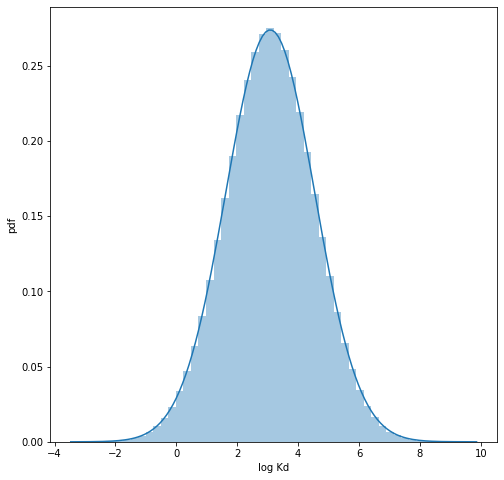

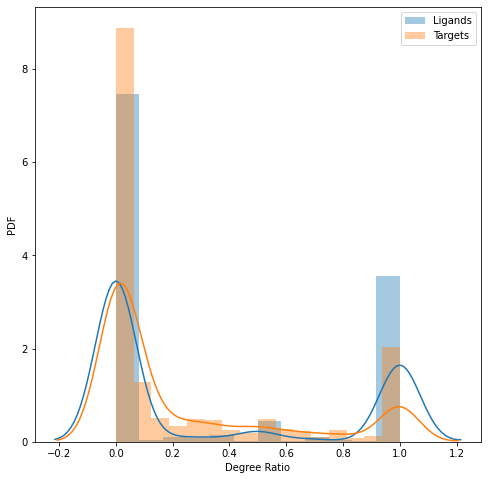

In [2]:
df = pd.read_csv('/home/sars-busters-consolidated/data/BindingDB_All.tsv', sep = '\t', error_bad_lines=False)
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = 'Kd (nM)'

df_want = df[df[idx_str].notnull()]
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                    'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                    'BindingDB Target Chain  Sequence', idx_str]]

df_want.rename(columns={'BindingDB Reactant_set_id':'ID', 'Ligand SMILES':'SMILES',\
                        'Ligand InChI':'InChI', 'PubChem CID':'PubChem_ID',
                        'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                        'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, inplace=True)

df_want['Label'] = df_want['Label'].str.replace('>', '')
df_want['Label'] = df_want['Label'].str.replace('<', '')
df_want['Label'] = df_want['Label'].astype(float)

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[(df_want.Label <= 10000000.0) & (df_want.Label != 0)]
#remove zeros
df_want=df_want[df_want['Label']>0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')

df_want_Kd = df_want[['SMILES','Target Sequence','Label']]

threshold = 30 ## DeepPurpose threshold in nM

df_want_Kd_binary = df_want_Kd.copy()
df_want_Kd_binary['Label'] = [1 if x < threshold else 0 for x in tqdm(df_want_Kd['Label'].tolist())]

ligands = list(set(df_want_Kd_binary['SMILES'].tolist()))
targets = list(set(df_want_Kd_binary['Target Sequence'].tolist()))

target_annotations_bindingDB = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations_bindingDB.append(len(sub_df))
    
print('Average annotations for proteins: ', np.mean(target_annotations_bindingDB))

p_original=df_want_Kd_binary['Label'].mean()

df_want_Kd_binary['Constant']=df_want_Kd['Label']
df_want_Kd_binary['Constant_log']=df_want_Kd_binary['Constant'].apply(np.log)
meanlog_constant=df_want_Kd_binary['Constant_log'].mean()
stdlog_constant=df_want_Kd_binary['Constant_log'].std()
df_want_Kd_binary=df_want_Kd_binary.sort_values(by=['Constant'])
print('Mean Log ', df_want_Kd_binary['Constant_log'].mean())
print('Std Log ', df_want_Kd_binary['Constant_log'].std())

ecdfkr =ECDF(df_want_Kd_binary['Constant_log'])
MAT=np.array([ecdfkr.x, ecdfkr.y, norm.ppf(ecdfkr.y, loc=meanlog_constant, scale=stdlog_constant)]).T
MAT=MAT[1:,:]
MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=meanlog_constant, scale=stdlog_constant)
df_want_Kd_binary['Constant_lognormal']=MAT[:,2]
df_want_Kd_binary['Constant_transformed']=np.exp(df_want_Kd_binary['Constant_lognormal'])

Tlog=max(df_want_Kd_binary['Constant_lognormal'][df_want_Kd_binary['Label']==1])
df_want_Kd_binary['Labelcheck']=[1 if x < Tlog else 0 for x in tqdm(df_want_Kd_binary['Constant_lognormal'].tolist())]

#tomonitor='Label'
tomonitor='Labelcheck'

#selectconstant='Constant'
selectconstant='Constant_transformed'


dictchem_kplus={}
dictchem_kminus={}
for chem in tqdm(ligands):
    dictchem_kplus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==1)
    dictchem_kminus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==0)
    
dictchem_k={chem:(dictchem_kplus[chem]+dictchem_kminus[chem]) for chem in ligands}
dictchem_ratio={chem:dictchem_kplus[chem]/dictchem_k[chem] for chem in ligands}

dicttarget_kplus={}
dicttarget_kminus={}
for t in tqdm(targets):
    dicttarget_kplus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==1)
    dicttarget_kminus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==0)
    
dicttarget_k={t:(dicttarget_kplus[t]+dicttarget_kminus[t]) for t in targets}
dicttarget_ratio={t:dicttarget_kplus[t]/dicttarget_k[t] for t in targets}

df_want_Kd_binary['k_l']=[dictchem_k[c] for c in df_want_Kd_binary['SMILES']]
df_want_Kd_binary['k_t']=[dicttarget_k[t] for t in df_want_Kd_binary['Target Sequence']]

kd_list = list(df_want_Kd_binary[selectconstant])
figure(figsize=(8, 8))
ax = sns.distplot(np.log10(kd_list), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')

figure(figsize=(8, 8))
sns.distplot(list(dictchem_ratio.values()), label='Ligands')
sns.distplot(list(dicttarget_ratio.values()), label='Targets')
plt.legend()
plt.xlabel('Degree Ratio')
plt.ylabel('PDF')


# log space
selectconstant_log='Constant_lognormal'
print('Number of proteins/nodes: ', len(targets))
target_annotations = []
target_average_Kd = []
target_std_Kd = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_average_Kd.append(np.mean(sub_df[selectconstant_log].tolist()))
    target_std_Kd.append(np.std(sub_df[selectconstant_log].tolist()))
    
different_target_annotations = sorted(list(set(target_annotations)))
unique_Kd_targets = []
unique_std_Kd_targets = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(target_average_Kd[j])
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    unique_std_Kd_targets.append(np.std(all_Kd_list))
    
    
print('Proteins - Correlation between node k and Kd: ', stats.spearmanr(target_annotations,target_average_Kd))
print('Proteins - Correlation between node k and Kd std: ', stats.spearmanr(target_annotations,target_std_Kd))
print('Proteins - Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations,unique_Kd_targets))
print('Proteins - Correlation between k and <Kd> std: ', stats.spearmanr(different_target_annotations,unique_std_Kd_targets))

dict_association={k: (m,s) for (k, m,s) in zip(different_target_annotations, unique_Kd_targets, unique_std_Kd_targets)}

# Analysis with original p_bind=0.16

In [22]:
kvec=sorted(target_annotations)
Goriginaldegree, Gpoisson, network_dataOrig, network_dataPois =correlated_networks(kvec, p_bind=p_original)

100%|██████████| 34822/34822 [00:04<00:00, 8352.46it/s]


Threshold Fat-tailed:  324.6984566723089
Threshold Poisson:  82.25715834441613


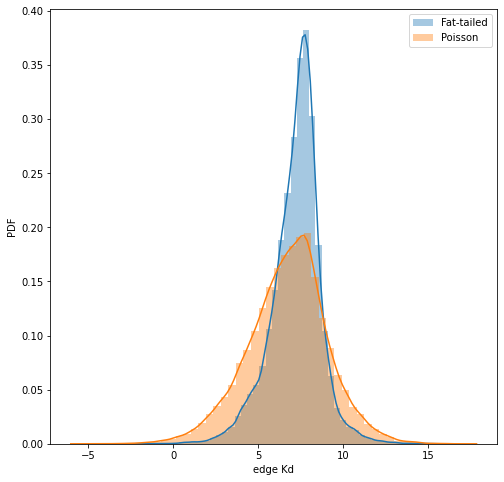

In [23]:
figure(figsize=(8, 8))
sns.distplot(np.log(network_dataOrig['edge_Kd']), label='Fat-tailed')
sns.distplot(np.log(network_dataPois['edge_Kd']), label= 'Poisson')
plt.legend()
plt.xlabel('edge Kd')
plt.ylabel('PDF');

100%|██████████| 1410/1410 [00:02<00:00, 489.67it/s]


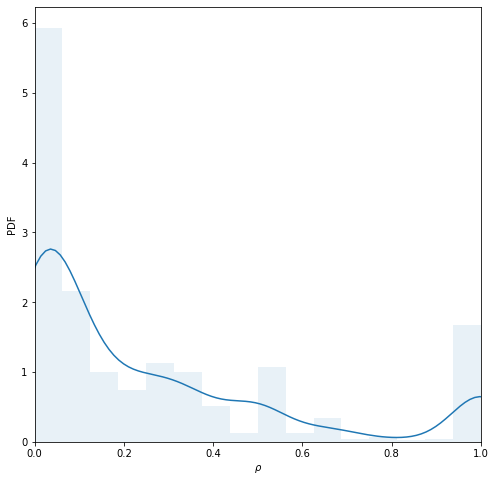

  0%|          | 2/10000 [00:00<11:41, 14.25it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.13976618391205722


  0%|          | 50/10000 [00:03<11:22, 14.57it/s]
91it [00:00, 903.07it/s]

Loops  51
Error margin:  [8.4457396e-06]


8597it [00:09, 904.38it/s]


AUC:  0.8364658409344776
AUP:  0.5401705468329567
Transductive performance:
AUC:  0.8406544262655959
AUP:  0.5435279371770284


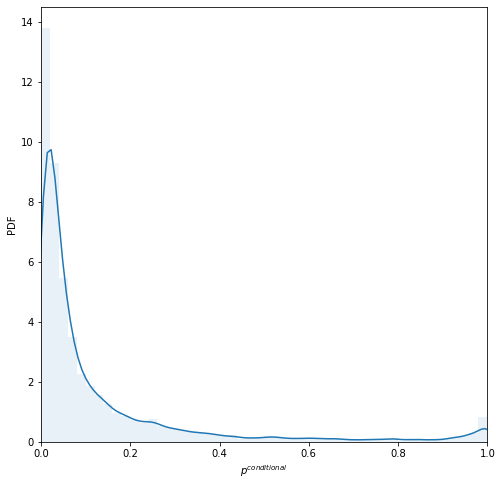

In [24]:
run_configuration_model(network_dataOrig)

100%|██████████| 158/158 [00:00<00:00, 4378.25it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.5871662211972454, pvalue=5.126947573837879e-16)


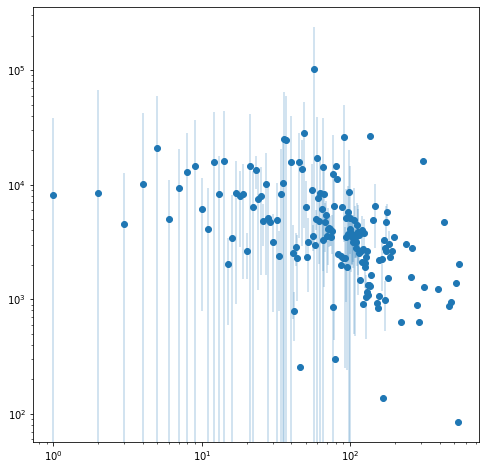

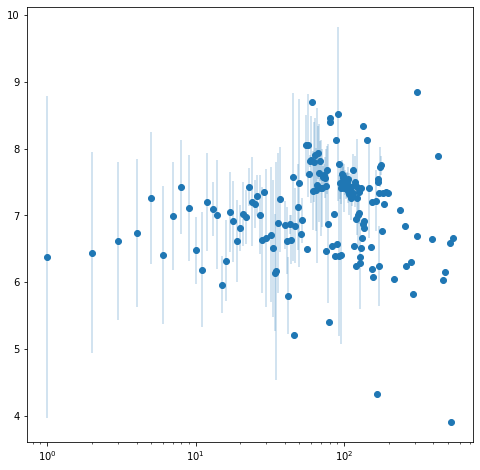

In [25]:
plot_k_Kd_relation(network_dataOrig)

100%|██████████| 1397/1397 [00:02<00:00, 470.91it/s]


Number of zero positive degree  311
Mean positive degree  3.9856836077308517
Std positive degree  12.314295969895467
%%%%%%%
Mean negative degree  24.730136005726557
Std negative degree  34.750045820398554
%%%%%%%
Mean degree  28.71581961345741
Std degree  40.19870278204278


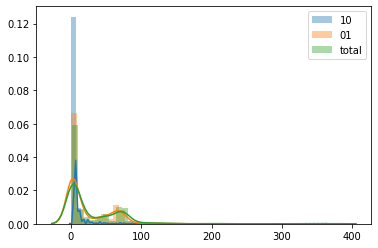

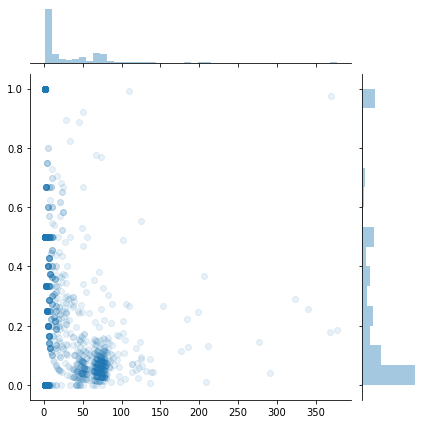

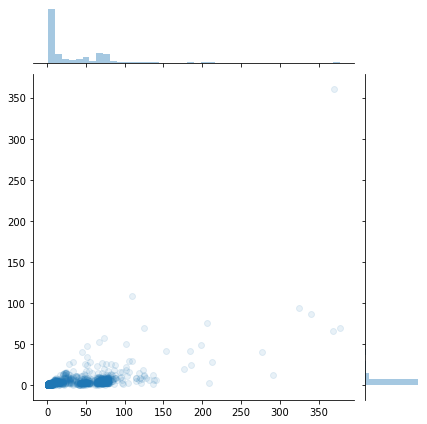

In [30]:
train, test = train_test_split(network_dataOrig, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

100%|██████████| 1507/1507 [00:03<00:00, 493.56it/s]


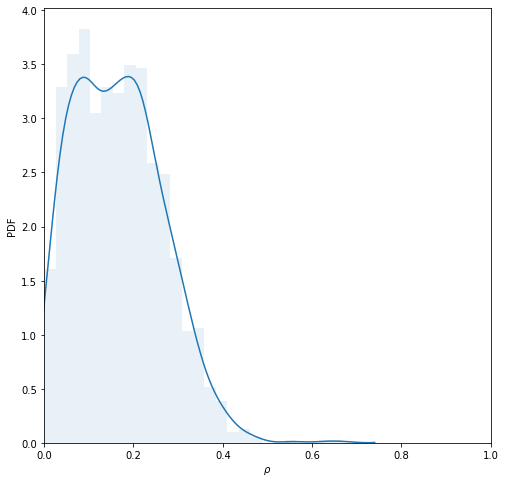

  0%|          | 2/10000 [00:00<13:18, 12.51it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15495950835678593


  6%|▌         | 617/10000 [00:46<11:52, 13.18it/s]
133it [00:00, 1321.50it/s]

Loops  618
Error margin:  [9.82415049e-06]


10447it [00:08, 1263.79it/s]


AUC:  0.6941418913027971
AUP:  0.26777154785551316
Transductive performance:
AUC:  0.6941418913027971
AUP:  0.26777154785551316


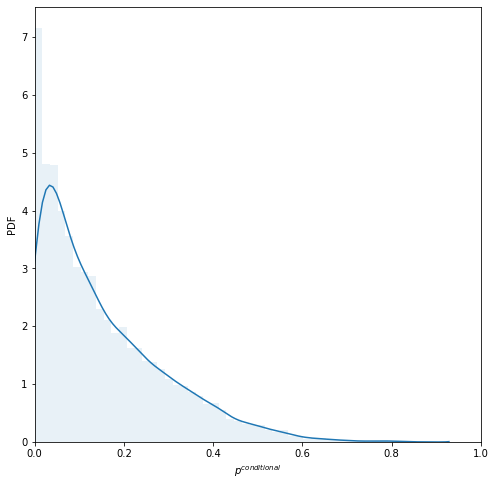

In [26]:
run_configuration_model(network_dataPois)

100%|██████████| 44/44 [00:00<00:00, 3332.66it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.5024665257223396, pvalue=0.0005095878823862864)


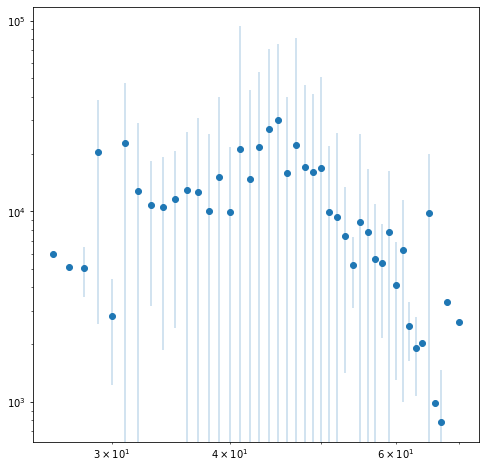

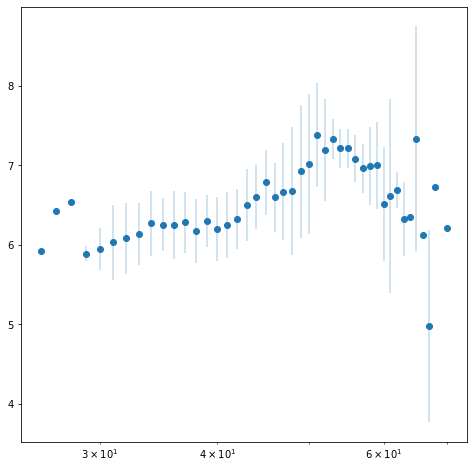

In [27]:
plot_k_Kd_relation(network_dataPois)

100%|██████████| 1507/1507 [00:03<00:00, 500.53it/s]


Number of zero positive degree  55
Mean positive degree  4.992700729927007
Std positive degree  3.008164041595379
%%%%%%%
Mean negative degree  27.356337093563372
Std negative degree  6.866421328355695
%%%%%%%
Mean degree  32.34903782349038
Std degree  5.613899123973462


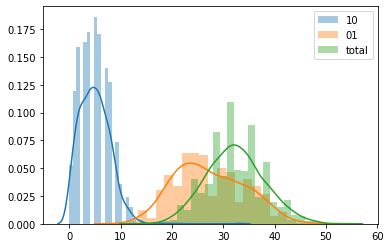

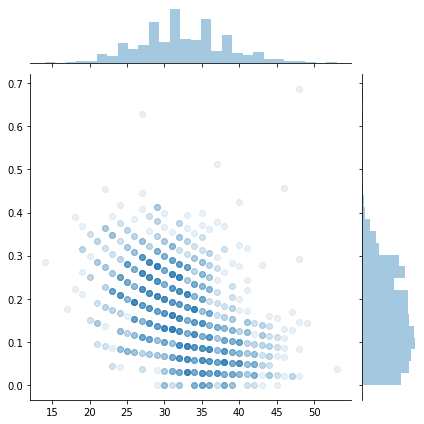

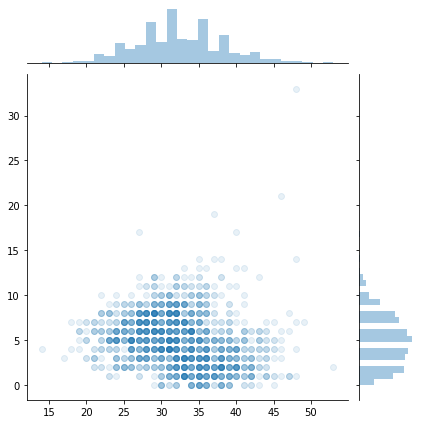

In [31]:
train, test = train_test_split(network_dataPois, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## Removing anti-correlation

  3%|▎         | 42/1383 [00:00<00:03, 419.66it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=0.12828958974597812, pvalue=0.10374861908678802)


100%|██████████| 1383/1383 [00:03<00:00, 436.09it/s]


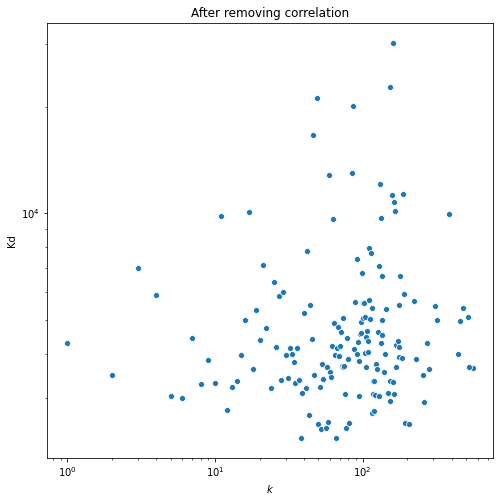

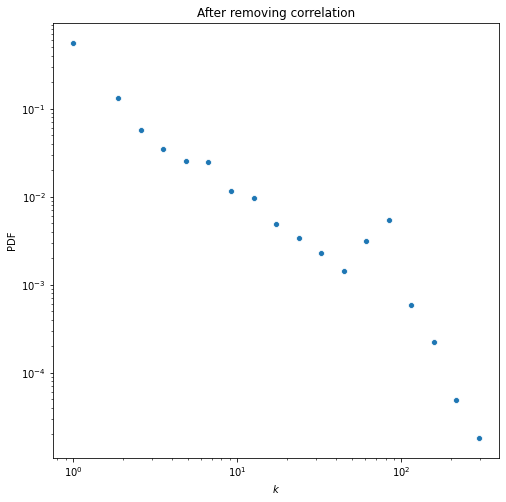

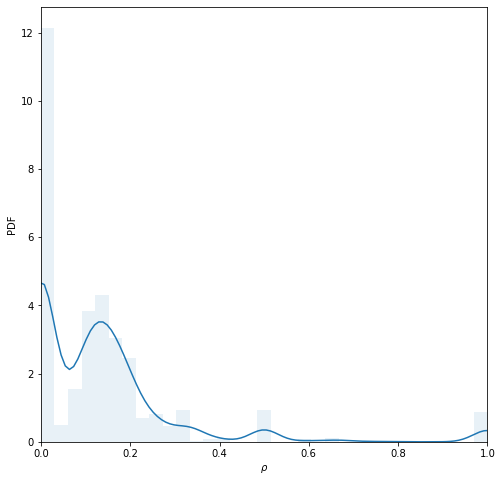

  0%|          | 2/10000 [00:00<11:17, 14.77it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.13934082815445847


  1%|          | 114/10000 [00:07<10:28, 15.73it/s]
98it [00:00, 978.41it/s]

Loops  115
Error margin:  [9.68479159e-06]


8593it [00:09, 941.53it/s]


AUC:  0.49245487141858746
AUP:  0.13771978927236242
Transductive performance:
AUC:  0.4924517370903087
AUP:  0.13808213950707648


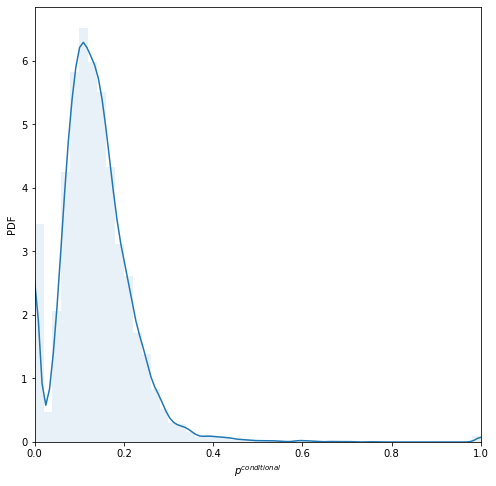

In [9]:
network_dataOrig_shuffled = remove_correlation_run_configuration_model(network_dataOrig, precision=10**(-5), loops=10000)

100%|██████████| 162/162 [00:00<00:00, 4190.35it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=0.12828958974597812, pvalue=0.10374861908678802)


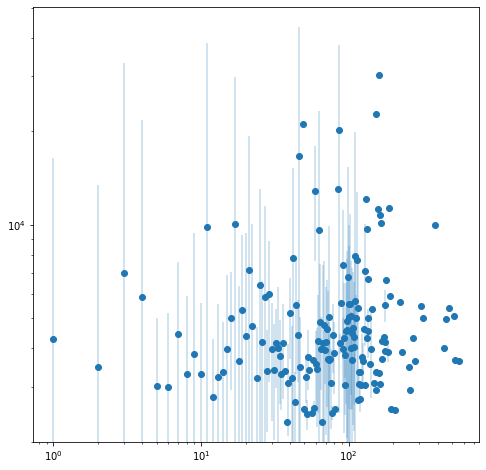

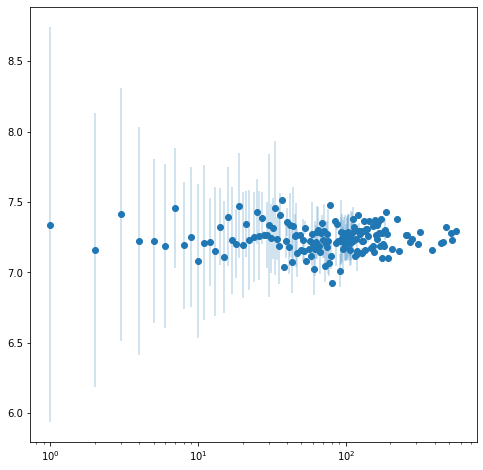

In [10]:
plot_k_Kd_relation(network_dataOrig_shuffled)

  3%|▎         | 50/1507 [00:00<00:02, 495.21it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=0.24176985804892784, pvalue=0.11830047228208382)


100%|██████████| 1507/1507 [00:03<00:00, 498.26it/s]


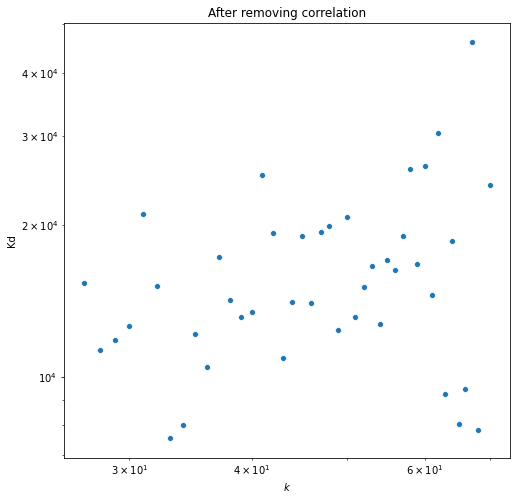

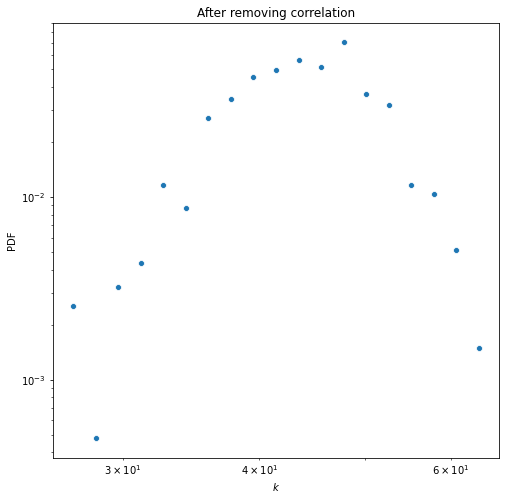

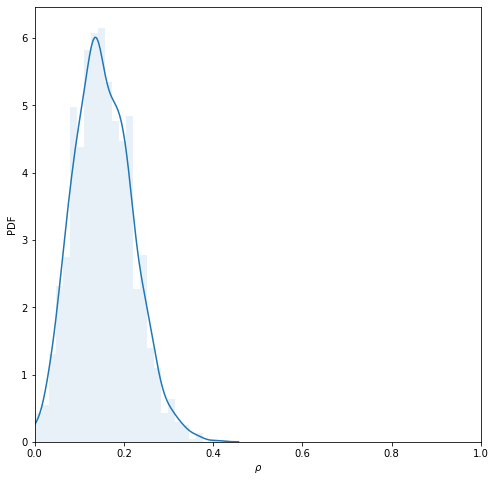

  0%|          | 2/10000 [00:00<13:34, 12.27it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15500804043188607


  5%|▍         | 488/10000 [00:36<11:52, 13.34it/s]
133it [00:00, 1318.30it/s]

Loops  489
Error margin:  [9.86843153e-06]


10448it [00:08, 1258.69it/s]


AUC:  0.4945241687160305
AUP:  0.1586101045599057
Transductive performance:
AUC:  0.4945241687160305
AUP:  0.1586101045599057


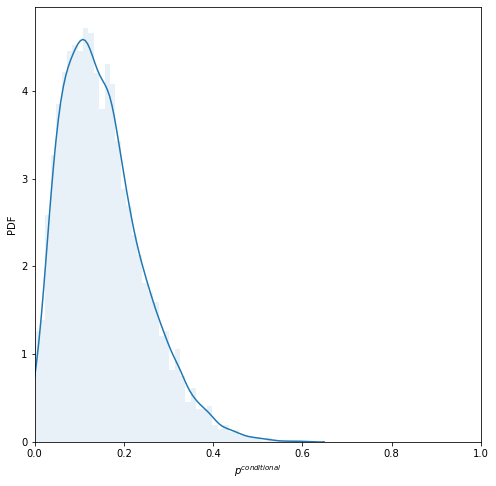

In [11]:
network_dataPois_shuffled = remove_correlation_run_configuration_model(network_dataPois, precision=10**(-5), loops=10000)

100%|██████████| 43/43 [00:00<00:00, 3910.39it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=0.24176985804892784, pvalue=0.11830047228208382)


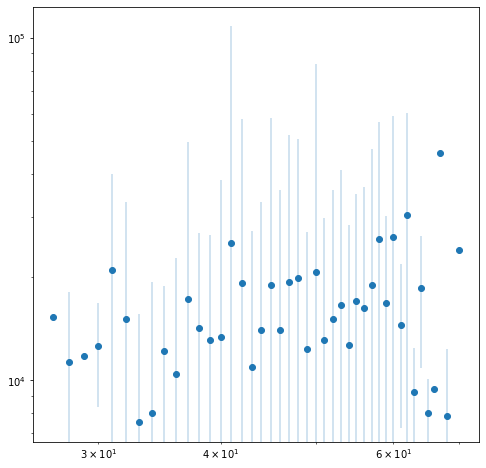

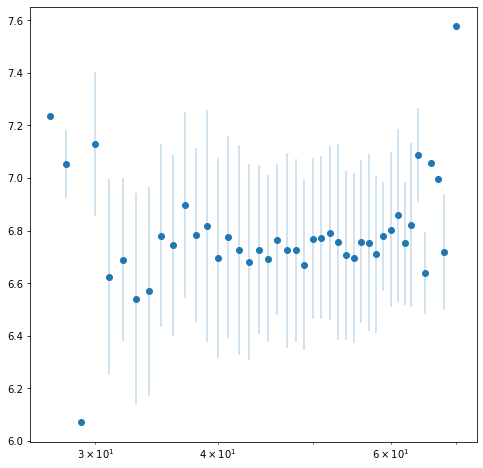

In [12]:
plot_k_Kd_relation(network_dataPois_shuffled)

# Analysis with  p_bind=0.5

In [13]:
kvec=sorted(target_annotations)
Goriginaldegree, Gpoisson, network_dataOrig, network_dataPois =correlated_networks(kvec)

100%|██████████| 34781/34781 [00:04<00:00, 8016.36it/s]


Threshold Fat-tailed:  1377.828475318442
Threshold Poisson:  836.2168169329088


100%|██████████| 1399/1399 [00:02<00:00, 483.23it/s]


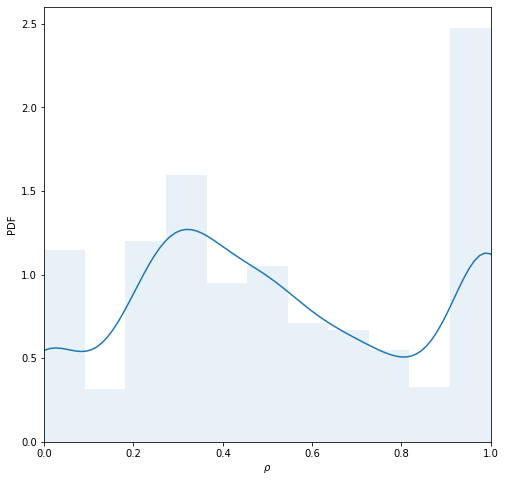

  0%|          | 2/10000 [00:00<11:22, 14.66it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.44006138606954764


  0%|          | 47/10000 [00:03<10:54, 15.21it/s]
85it [00:00, 843.87it/s]

Loops  48
Error margin:  [9.73845307e-06]


8602it [00:09, 924.70it/s]


AUC:  0.8593191516742255
AUP:  0.799990294438256
Transductive performance:
AUC:  0.8611506284845208
AUP:  0.8002277969998457


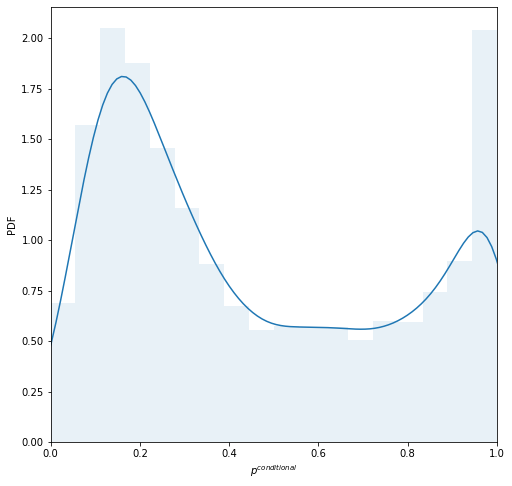

In [14]:
run_configuration_model(network_dataOrig)

100%|██████████| 154/154 [00:00<00:00, 4464.59it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.5135217723453018, pvalue=9.730908117373842e-12)


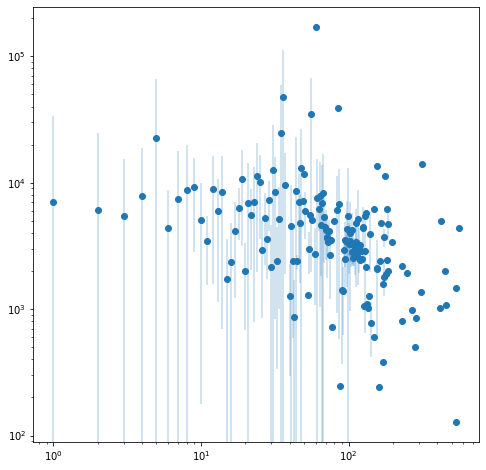

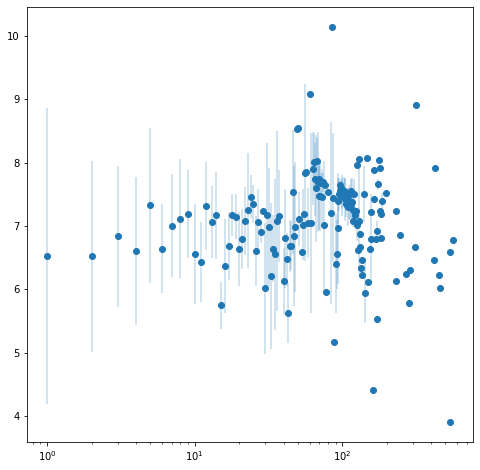

In [15]:
plot_k_Kd_relation(network_dataOrig)

100%|██████████| 1507/1507 [00:03<00:00, 486.86it/s]


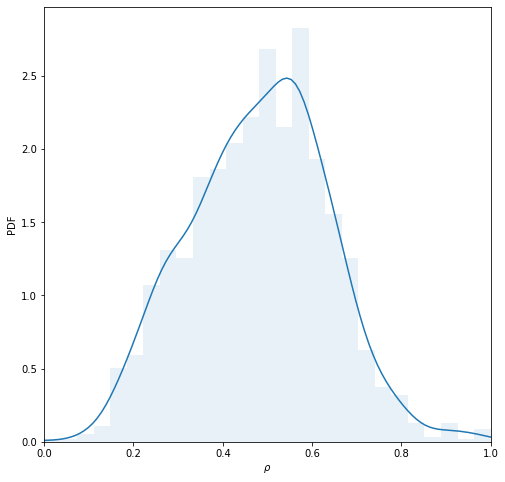

  0%|          | 2/10000 [00:00<13:19, 12.50it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.47002673873666656


  4%|▍         | 438/10000 [00:32<11:57, 13.33it/s]
128it [00:00, 1273.09it/s]

Loops  439
Error margin:  [9.96576601e-06]


10435it [00:08, 1254.85it/s]


AUC:  0.6777083209779722
AUP:  0.6337710590688137
Transductive performance:
AUC:  0.6777083209779722
AUP:  0.6337710590688137


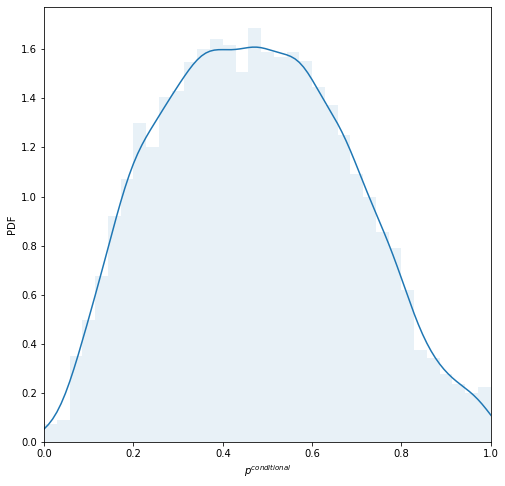

In [16]:
run_configuration_model(network_dataPois)

100%|██████████| 41/41 [00:00<00:00, 3650.94it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.522822299651568, pvalue=0.00045335567958377756)


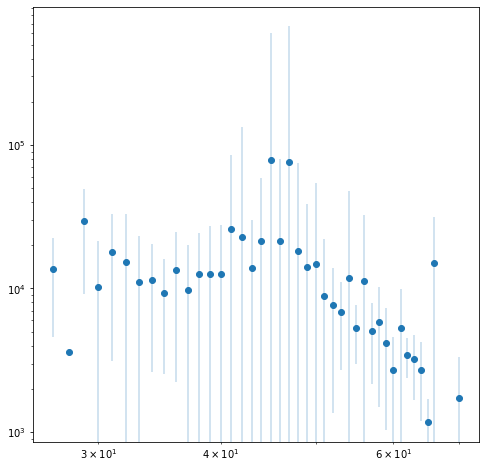

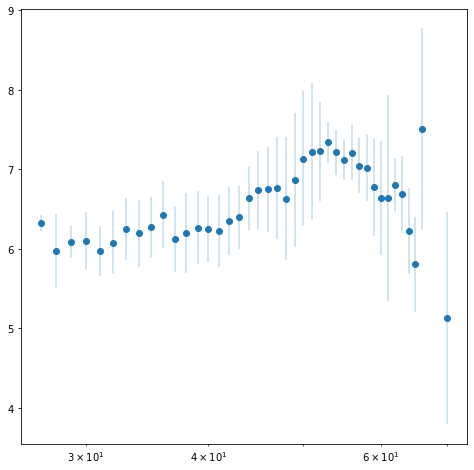

In [17]:
plot_k_Kd_relation(network_dataPois)

## Removing anti-correlation

  6%|▌         | 86/1397 [00:00<00:03, 408.82it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=0.06646952035946344, pvalue=0.41275737199243223)


100%|██████████| 1397/1397 [00:02<00:00, 468.28it/s]


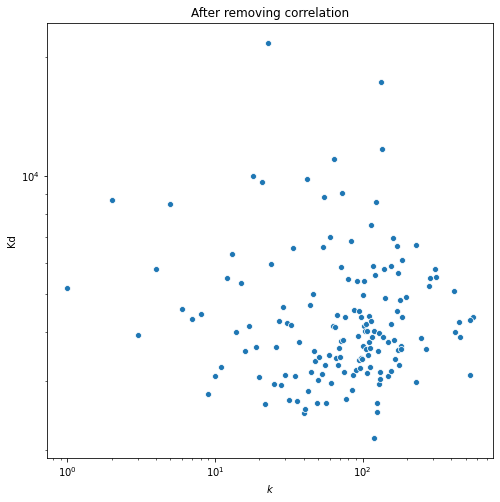

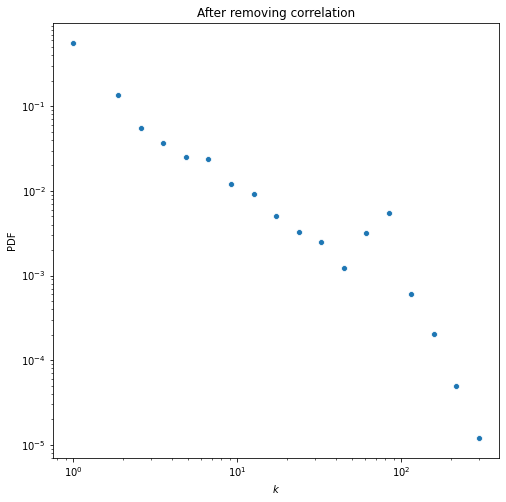

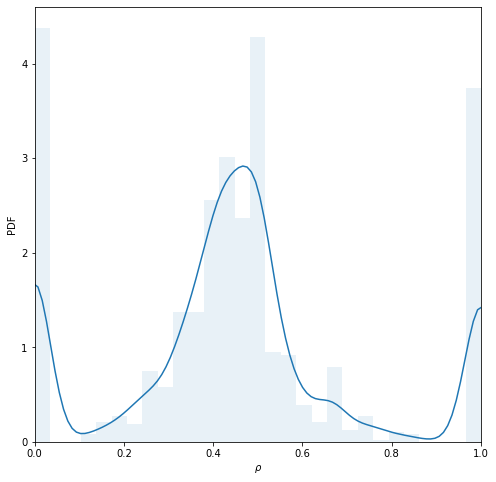

  0%|          | 2/10000 [00:00<11:00, 15.14it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.44006138606954764


  1%|          | 68/10000 [00:04<10:47, 15.33it/s]
96it [00:00, 955.64it/s]

Loops  69
Error margin:  [9.0699646e-06]


8602it [00:09, 923.29it/s]


AUC:  0.5045339725836976
AUP:  0.44114111129461697
Transductive performance:
AUC:  0.5051930653407168
AUP:  0.4415790128309071


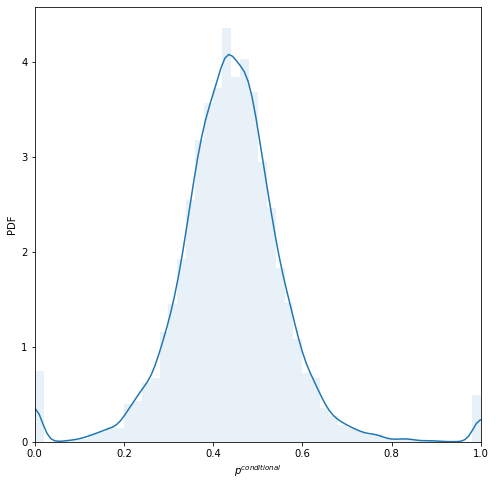

In [18]:
network_dataOrig_shuffled = remove_correlation_run_configuration_model(network_dataOrig, precision=10**(-5), loops=10000)

100%|██████████| 154/154 [00:00<00:00, 4479.70it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=0.06646952035946344, pvalue=0.41275737199243223)


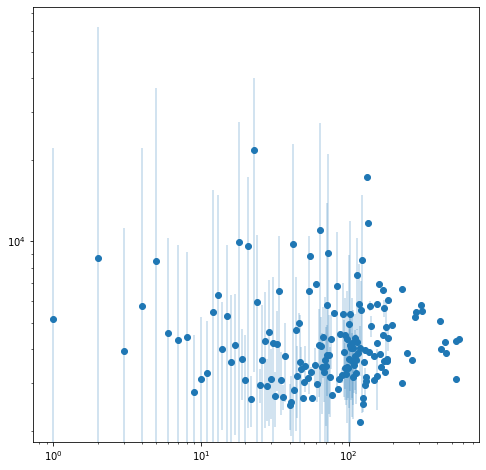

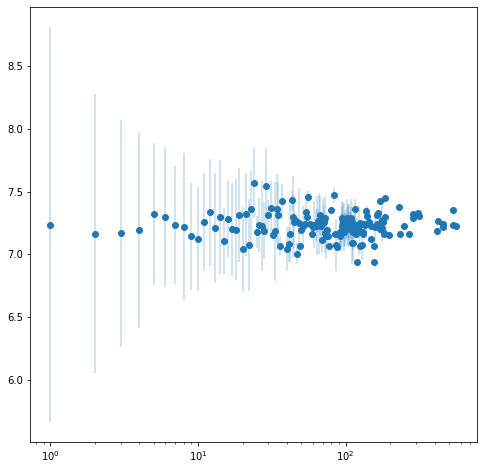

In [19]:
plot_k_Kd_relation(network_dataOrig_shuffled)

  3%|▎         | 50/1507 [00:00<00:02, 499.21it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.09024390243902441, pvalue=0.574715784367521)


100%|██████████| 1507/1507 [00:03<00:00, 502.26it/s]


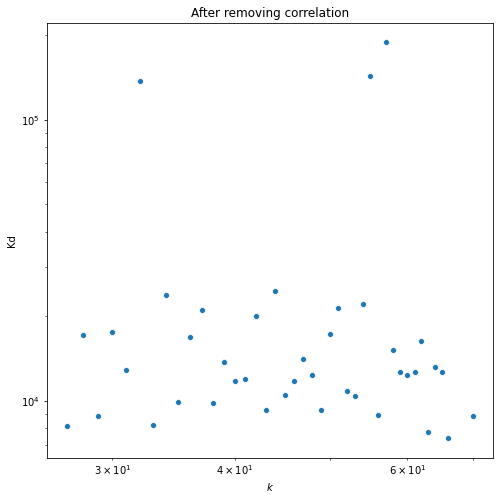

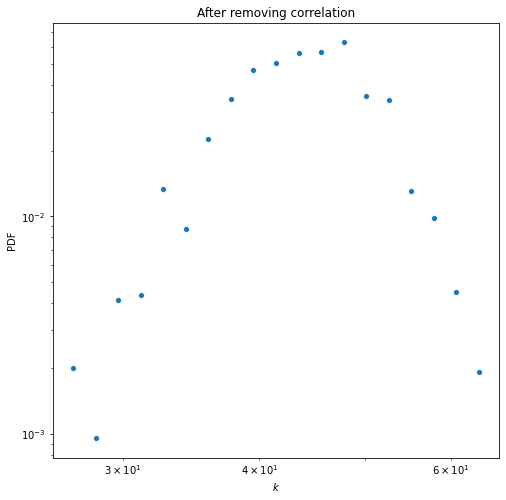

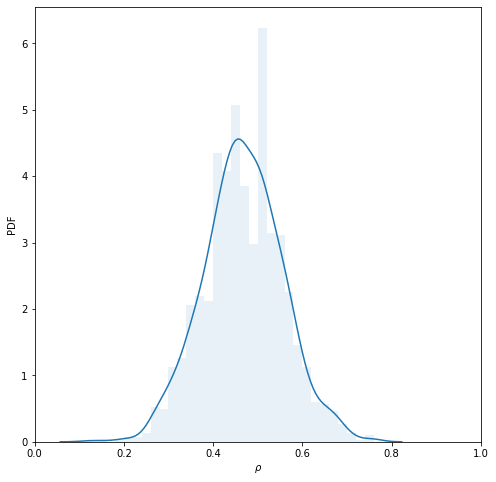

  0%|          | 2/10000 [00:00<13:18, 12.52it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.47002673873666656


  5%|▍         | 490/10000 [00:36<11:52, 13.35it/s]
127it [00:00, 1261.87it/s]

Loops  491
Error margin:  [9.69034493e-06]


10435it [00:08, 1289.58it/s]


AUC:  0.49251374670714126
AUP:  0.4728652712639735
Transductive performance:
AUC:  0.49251374670714126
AUP:  0.4728652712639735


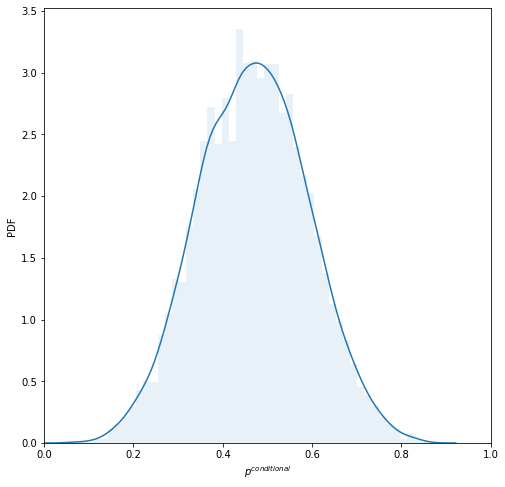

In [20]:
network_dataPois_shuffled = remove_correlation_run_configuration_model(network_dataPois, precision=10**(-5), loops=10000)

100%|██████████| 41/41 [00:00<00:00, 3805.58it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.09024390243902441, pvalue=0.574715784367521)


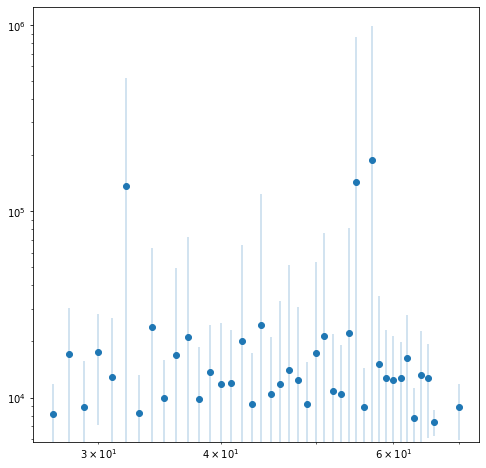

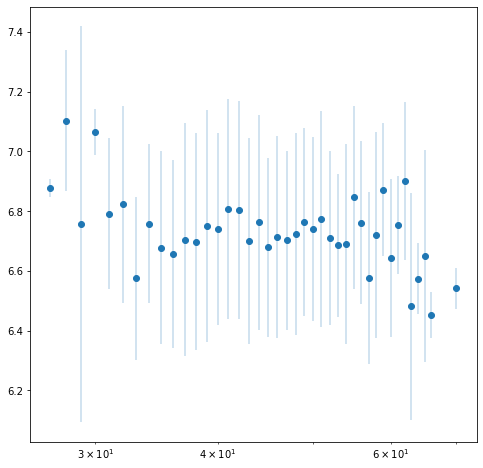

In [21]:
plot_k_Kd_relation(network_dataPois_shuffled)